In [1]:
import re 
import os 
import sys

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import scanpy as sc
import anndata as ad

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

# Read files

In [3]:
# Read adata
path = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / '05_v1.h5ad'
adata = sc.read_h5ad(path)
centroids = adata.obsm["spatial"]
print(adata)

# Get info
cell = adata.obs.Cell.tolist()
roi = adata.obs.ROI.tolist()
cell_roi = adata.obs.Cell_ROI.tolist()

# Cell id mapping for ROI et cell id in roi to whole tissue cell id
mapping = dict(zip(list(zip(roi, cell_roi)), cell))

# Read all existing gate name
gating_path = data_dir / 'GC Database' / 'new_exported FlowJo MCMICRO'  / 'th_scale_values'
names = []
for (dirpath, dirnames, filenames) in os.walk(gating_path):
    for name in tqdm(sorted(filenames)):
        if 'csv' not in name:
            continue
        names.append(name.split('_')[-1].split('.')[0])
        
        
# Define phenotype to keep 
keep = ['CD3+CD20-', 'CD3-CD20+', 'Cytotoxic T-cells (CD3+C8+)', 'DZ B-cells (CD20+Ki67+)', 'Endothelial cells (CD31+ )', 
        'Epithelial Cells (Keratin+)', 'Exhausted T-cells (PD-1+)', 'Helper T-cells (CD3+CD4+)', 'M2 Macrophages CD68+CD136+',
        'PD-L1+ M2 Macrophages', 'Stromal Cells (aSMA+)+Stromal Cells (Ecad+)+Stromal Cells (Vimentin+)+', 'Stromal Cells (aSMA+)+Stromal Cells (Ecad+)+Stromal Cells (Vimentin+)-',
        'Stromal Cells (aSMA+)+Stromal Cells (Ecad+)-Stromal Cells (Vimentin+)+', 'Stromal Cells (aSMA+)+Stromal Cells (Ecad+)-Stromal Cells (Vimentin+)-', 
        'Stromal Cells (aSMA+)-Stromal Cells (Ecad+)+Stromal Cells (Vimentin+)+', 'Stromal Cells (aSMA+)-Stromal Cells (Ecad+)+Stromal Cells (Vimentin+)-', 
        'Stromal Cells (aSMA+)-Stromal Cells (Ecad+)-Stromal Cells (Vimentin+)+', 'Stromal Cells (aSMA+)-Stromal Cells (Ecad+)-Stromal Cells (Vimentin+)-', 'Treg cells (FoxP3+)']

# Loop through data
phenotypes = []
dfs = []
for (dirpath, dirnames, filenames) in os.walk(gating_path):
    for name in tqdm(sorted(filenames)):
        if 'csv' not in name:
            continue
        phenotype = name.split('_')[-1].split('.')[0]
        if phenotype in keep:
            df = pd.read_csv(os.path.join(dirpath, name))
            df['Phenotype'] = phenotype
            phenotypes.append(phenotype)
            dfs.append(df)   

# Concatenate
df = pd.concat(dfs)
df['Cell_mapped'] = df.apply(lambda x: mapping[(x['ROI'], x['Cell_ROI'])], axis=1)

# Check number of duplicated gates
df.duplicated(subset=['ROI', 'Cell_ROI']).value_counts()

df_new = df.drop_duplicates(subset=['ROI', 'Cell_ROI'], keep='last')
df_new.columns

phenotypes_mapped = ['T-cells', 'B-cells', 'Cytotoxic T-cells', 'DZ B-cells', 'Endothelial cells', 'Epithelial Cells', 'Exhausted T-cells', 'Helper T-cells', 'M2 Macrophages', 'PD-L1+ M2 Macrophages', 
                     'Stromal Cells (aSMA+Ecad+Vimentin+)','Stromal Cells (aSMA+Ecad+Vimentin-)', 'Stromal Cells (aSMA+Ecad-Vimentin+)', 'Stromal Cells (aSMA+Ecad-Vimentin-)',
                     'Stromal Cells (aSMA-Ecad+Vimentin+)', 'Stromal Cells (aSMA-Ecad+Vimentin-)', 'Stromal Cells (aSMA-Ecad-Vimentin+)', 'Stromal Cells (aSMA-Ecad-Vimentin-)', 'Treg cells']
p_mapping = dict(zip(phenotypes, phenotypes_mapped))

df_new['Phenotype_mapped'] = df_new.apply(lambda x: p_mapping[x['Phenotype']], axis=1)

AnnData object with n_obs × n_vars = 1529537 × 36
    obs: 'ROI', 'Cell', 'Cell_ROI', 'Data', 'Foll', 'GC'
    obsm: 'spatial'


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_38656\4237594953.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Phenotype_mapped'] = df_new.apply(lambda x: p_mapping[x['Phenotype']], axis=1)


# Create anndata

In [6]:
markers = ['A488', 'A555', 'A647', 'CD11c_555', 'CD163_488', 'CD20_488',
       'CD31_647', 'CD45_647', 'CD4_570', 'CD68_488', 'CD8a_488',
       'Catenin_647', 'Ecad_488', 'FOXP3_570', 'H2ax_647',
       'H3_PE', 'Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5',
       'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Keratin_570',
       'Ki67_488', 'LaminAC_488', 'PD1_647', 'PDL1_647', 'Vimentin_555',
       'aSMA_660', 'anti_CD3', 'anti_CD45RO', 'anti_NaKATPase',
       'pH3_555']
obs = ['ROI', 'Cell_ROI', 'Cell_mapped', 'X', 'Y', 'Phenotype', 'Phenotype_mapped']

adata = ad.AnnData(df_new.loc[:,markers])
adata.var_names = markers
adata.obs = df_new.loc[:,obs]
adata.obsm['spatial'] = df_new[['Y', 'X']].values

C:\Users\thu71\AppData\Local\Temp\ipykernel_38656\4148546878.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(df_new.loc[:,markers])
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 4, 5]

    Inferred to be: in

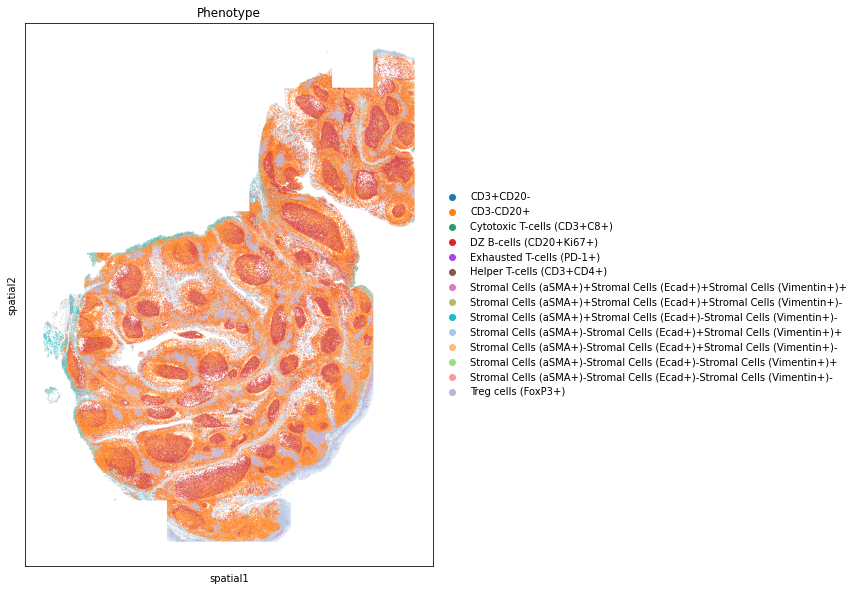

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.spatial(adata, ax=ax, color='Phenotype', spot_size=15)

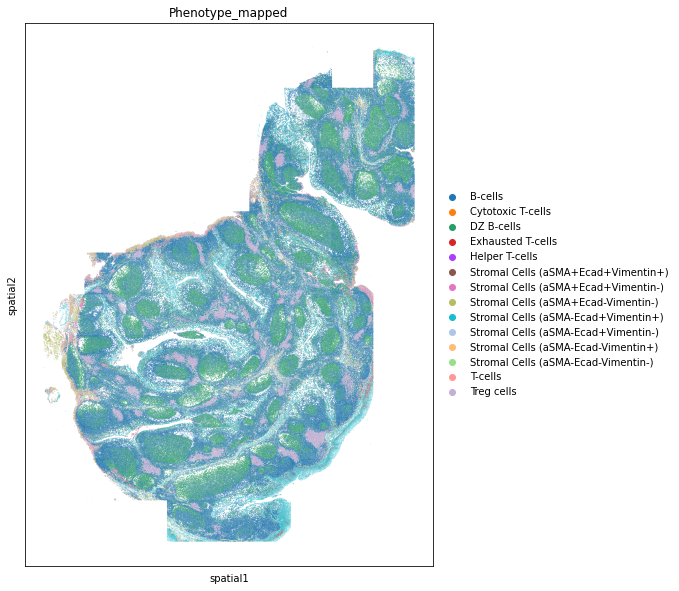

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.spatial(adata, ax=ax, color='Phenotype_mapped', spot_size=15)

# Unsupervised clustering

In [5]:
adata_path = data_dir / "metadata" / f"mcmicro.h5ad"


In [9]:
import openTSNE

In [10]:
sc.pp.scale(adata, max_value=4)

In [12]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    adata.X,
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: total: 35min 18s
Wall time: 6min 29s


In [13]:
%%time
init = openTSNE.initialization.pca(adata.X, random_state=0)

CPU times: total: 59 s
Wall time: 2.82 s


In [14]:
%%time
embedding = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=106321.83 for 250 iterations...
Iteration   50, KL divergence 8.9195, 50 iterations in 54.3905 sec
Iteration  100, KL divergence 8.6343, 50 iterations in 57.2563 sec
Iteration  150, KL divergence 8.5984, 50 iterations in 62.6886 sec
Iteration  200, KL divergence 8.5888, 50 iterations in 63.9226 sec
Iteration  250, KL divergence 8.5857, 50 iterations in 64.4148 sec
   --> Time elapsed: 302.67 seconds
===> Running optimization with exaggeration=1.00, lr=106321.83 for 500 iterations...
Iteration   50, KL divergence 6.8162, 50 iterations in 60.1555 sec
Iteration  100, KL divergence 6.2442, 50 iterations in 63.8467 sec
Iteration  150, KL divergence 5.9183, 50 iterations in 56.5356 sec
Iteration  200, KL divergence 5.7007, 50 iterations in 56.4068 se

In [32]:
adata.obsm['X_tsne'] = np.array(embedding)
adata.obs['ROI'] = adata.obs['ROI'].astype(np.uint8)
adata.obs['Cell_ROI'] = adata.obs['Cell_ROI'].astype(np.uint32)

In [33]:
adata.write(adata_path)

In [34]:
adata

AnnData object with n_obs × n_vars = 1275862 × 36
    obs: 'ROI', 'Cell_ROI', 'Cell_mapped', 'X', 'Y', 'Phenotype', 'Phenotype_mapped'
    var: 'mean', 'std'
    uns: 'Phenotype_colors', 'Phenotype_mapped_colors'
    obsm: 'spatial', 'X_tsne'

In [6]:
adata = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\cle_39\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\cle_39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
sc.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:27)


In [8]:
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (4:35:10)


In [9]:
adata.write(adata_path)

# Viz

In [3]:
adata_path = data_dir / "metadata" / f"mcmicro.h5ad"
adata = ad.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
